<a href="https://colab.research.google.com/github/emm-gl/WA2501_Machine_Learning_AI/blob/main/M%26DL2501-Math%26DeepLearning/Bloque02/DL_Semana2_GroceryStore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports

In [3]:
import os
import cv2
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix

import matplotlib.pyplot as plt

In [ ]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# 1. Dataset

https://www.kaggle.com/datasets/validmodel/grocery-store-dataset/data

In [38]:
!ls /content

Dataset.zip  sample_data


In [ ]:
!unzip /content/Dataset.zip

In [40]:
data_dir = "/content/GroceryStoreDataset/dataset"

img_size = (180, 180)
batch_size = 32
seed = 42

In [41]:
df_classes = pd.read_csv(data_dir + "/classes.csv")
df_classes.sample(5)

,Class Name (str),Class ID (int),Coarse Class Name (str),Coarse Class ID (int),Iconic Image Path (str),Product Description Path (str)
52,Alpro-Shelf-Soy-Milk,52,Soy-Milk,26,/iconic-images-and-descriptions/Packages/Soy-M...,/iconic-images-and-descriptions/Packages/Soy-M...
39,Arla-Lactose-Medium-Fat-Milk,39,Milk,20,/iconic-images-and-descriptions/Packages/Milk/...,/iconic-images-and-descriptions/Packages/Milk/...
1,Granny-Smith,1,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Gr...,/iconic-images-and-descriptions/Fruit/Apple/Gr...
74,Solid-Potato,74,Potato,39,/iconic-images-and-descriptions/Vegetables/Pot...,/iconic-images-and-descriptions/Vegetables/Pot...
13,Honeydew-Melon,13,Melon,7,/iconic-images-and-descriptions/Fruit/Melon/Ho...,/iconic-images-and-descriptions/Fruit/Melon/Ho...


In [42]:
coarse_mapping = dict(df_classes[["Coarse Class ID (int)", "Coarse Class Name (str)"]].drop_duplicates().values)

In [43]:
filter_img = [0,1,2]

In [44]:
coarse_mapping = {k: v for k, v in coarse_mapping.items() if k in filter_img}
coarse_mapping

{0: 'Apple', 1: 'Avocado', 2: 'Banana'}

In [46]:
df_train = pd.read_csv(url_train,names= ['path','fine','coarse'])
df_val = pd.read_csv(url_val,names= ['path','fine','coarse'])
df_test = pd.read_csv(url_test,names= ['path','fine','coarse'])

In [47]:
df_train = df_train[df_train.coarse.isin(filter_img)]
df_val = df_val[df_val.coarse.isin(filter_img)]
df_test = df_test[df_test.coarse.isin(filter_img)]

In [48]:
df_train.sample(5)

,path,fine,coarse
274,test/Fruit/Apple/Royal-Gala/Royal-Gala_063.jpg,4,0
145,test/Fruit/Apple/Pink-Lady/Pink-Lady_043.jpg,2,0
276,test/Fruit/Avocado/Avocado_001.jpg,5,1
132,test/Fruit/Apple/Pink-Lady/Pink-Lady_030.jpg,2,0
342,test/Fruit/Banana/Banana_027.jpg,6,2


In [49]:
image  = cv2.imread(data_dir + '/train/Fruit/Apple/Golden-Delicious/Golden-Delicious_001.jpg')
image.shape

(348, 348, 3)

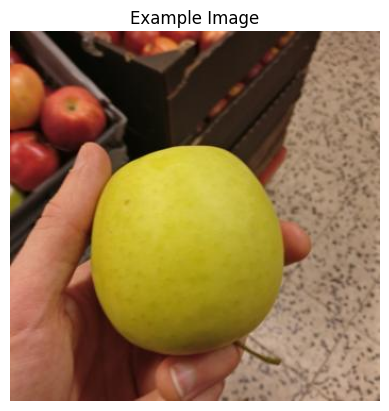

In [ ]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Example Image")
plt.axis("off")
plt.show()

In [50]:
df_train["coarse_name"] = df_train["coarse"].map(coarse_mapping)
counts = df_train["coarse_name"].value_counts()

In [51]:
counts

,count
coarse_name,
Apple,276
Banana,44
Avocado,40


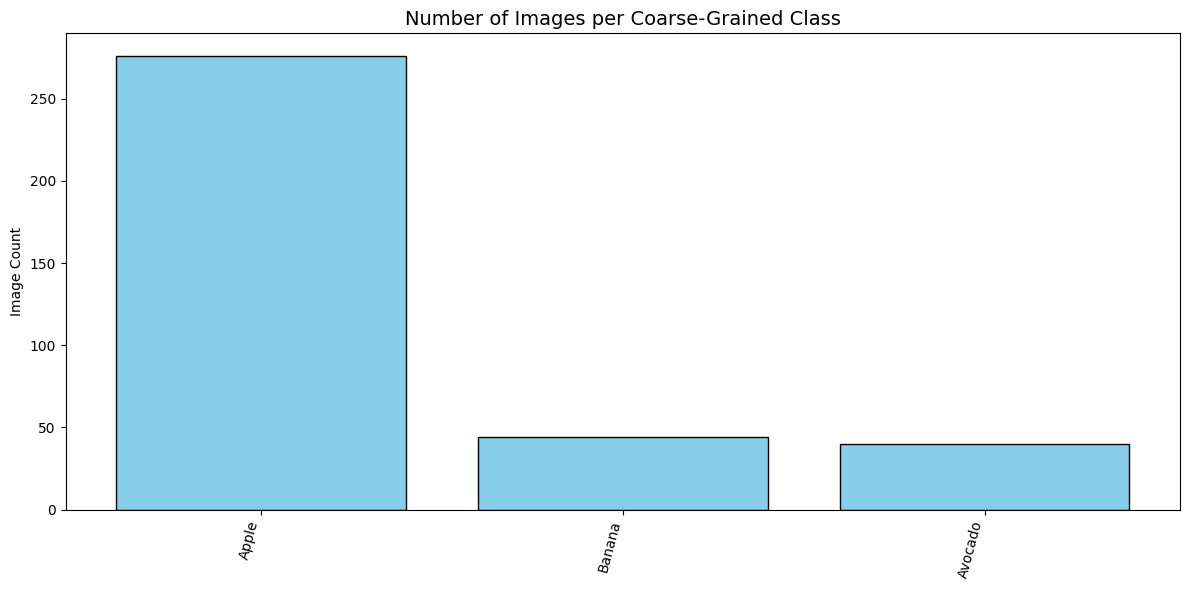

In [52]:
plt.figure(figsize=(12, 6))
plt.bar(counts.index, counts.values, color="skyblue", edgecolor="black")
plt.title("Number of Images per Coarse-Grained Class", fontsize=14)
plt.ylabel("Image Count")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()

# 2. Load Dataset with Train/Val/Test

In [53]:
def load_images_from_folder(paths):
    image_ds = []
    for path in paths:
        s = data_dir + '/' + path
        img = cv2.imread(s)
        resized = cv2.resize(img,img_size)
        image_ds.append(resized)

    image_array = np.array(image_ds)
    X = image_array/255
    return X

In [54]:
X_train = load_images_from_folder(df_train['path'].values)
X_val = load_images_from_folder(df_val['path'].values)
X_test = load_images_from_folder(df_test['path'].values)

In [55]:
X_train.shape

(360, 180, 180, 3)

In [56]:
X_val.shape

(364, 180, 180, 3)

In [57]:
X_test.shape

(33, 180, 180, 3)

In [58]:
y_train = np.array(df_train['coarse'])
y_val = np.array(df_val['coarse'])
y_test = np.array(df_test['coarse'])

In [59]:
train_counts = dict(zip(counts.index, counts.values))

In [60]:
train_counts

{'Apple': np.int64(276), 'Banana': np.int64(44), 'Avocado': np.int64(40)}

In [ ]:
# Balance dataset

In [ ]:
class_counts = Counter(y_train)
print("Distribución de clases original:")
print(class_counts)

Distribución de clases original:
Counter({0: 278, 2: 45, 1: 41})


In [ ]:
max_count = max(class_counts.values())

In [61]:
# --- 2. Crear generador de data augmentation ---
datagen = ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

In [62]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
np.unique(y_train)

array([0, 1, 2])

In [ ]:
# --- 3. Oversampling dinámico ---
X_aug = []
y_aug = []

In [ ]:
for cls in np.unique(y_train):
    idx = np.where(y_train == cls)[0]
    X_cls = X_train[idx]
    n_current = len(X_cls)
    n_to_generate = 500 #max_count - n_current

    if n_to_generate > 0:
        print(f"Clase {cls}: generando {n_to_generate} imágenes aumentadas")
        gen = datagen.flow(X_cls, batch_size=1)

        for i in range(n_to_generate):
            new_img = next(gen)[0]
            X_aug.append(new_img)
            y_aug.append(cls)

Clase 0: generando 500 imágenes aumentadas
Clase 1: generando 500 imágenes aumentadas
Clase 2: generando 500 imágenes aumentadas


In [ ]:
# --- 4. Combinar dataset original + aumentado ---
if X_aug:
    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)
    X_train_balanced = np.concatenate([X_train, X_aug], axis=0)
    y_train_balanced = np.concatenate([y_train, y_aug], axis=0)
else:
    X_train_balanced, y_train_balanced = X_train, y_train

print("\nDistribución balanceada final:")
print(Counter(y_train_balanced))


Distribución balanceada final:
Counter({0: 778, 2: 545, 1: 541})


In [ ]:
# Generate a random permutation of indices
permutation = np.random.permutation(len(X_train_balanced))

# Apply the permutation to both X and y
X_train_balanced = X_train_balanced[permutation]
y_train_balanced = y_train_balanced[permutation]

In [ ]:
permutation

array([1143,  836, 1224, ..., 1078,  513, 1317])

# 3. Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.2),
    #layers.RandomContrast(0.15),
    #layers.RandomBrightness(0.15),
])


I0000 00:00:1764971211.423555  146126 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12342 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:07:00.0, compute capability: 8.9


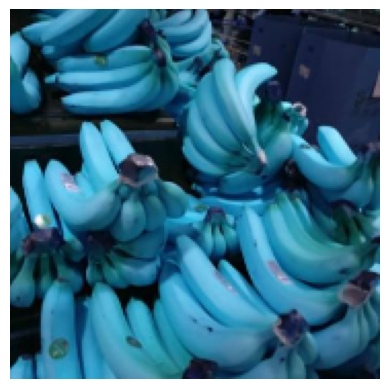

In [ ]:
plt.axis('off')
plt.imshow(X_train[360])

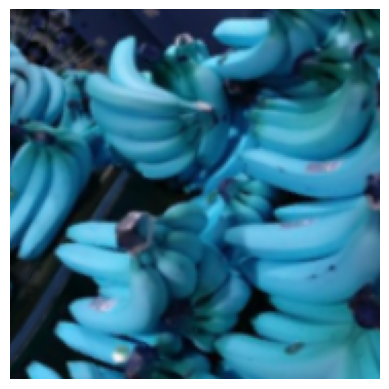

In [ ]:
plt.axis('off')
plt.imshow(data_augmentation(X_train)[360])

In [ ]:
num_classes = len(coarse_mapping)
num_classes

3

In [ ]:
img_size + (3,)

(180, 180, 3)

# 4. Define CNN Model

In [ ]:
# model = models.Sequential([
#     layers.Input(shape=img_size + (3,)),

#     layers.Conv2D(32, (3,3), padding='same'),
#     layers.BatchNormalization(),
#     layers.ReLU(),
#     layers.MaxPooling2D(),

#     layers.Conv2D(64, (3,3), padding='same'),
#     layers.BatchNormalization(),
#     layers.ReLU(),
#     layers.MaxPooling2D(),

#     layers.Conv2D(128, (3,3), padding='same'),
#     layers.BatchNormalization(),
#     layers.ReLU(),
#     layers.MaxPooling2D(),

#     layers.Conv2D(256, (3,3), padding='same'),
#     layers.BatchNormalization(),
#     layers.ReLU(),
#     layers.GlobalAveragePooling2D(),

#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.2),
#     layers.Dense(num_classes, activation='softmax')
# ])

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

In [ ]:
# --- 1. Modelo base preentrenado ---
# base_model = applications.InceptionV3(
#     include_top=False,
#     weights="imagenet",
#     input_shape=img_size + (3,)
# )

base_model = applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)


base_model.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(base_model.input, outputs)


/tmp/ipykernel_146126/217761196.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(


# 5. Compile Model

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy'
    ]
)

# 6. Train Model

In [ ]:
num_epochs = 1000

history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val),
    epochs=num_epochs,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=3)
    ]
)

Epoch 1/1000


2025-12-05 17:31:33.806872: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-05 17:31:33.885282: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4613 - loss: 1.0394

2025-12-05 17:31:44.532682: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-05 17:31:44.616099: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.4627 - loss: 1.0373

2025-12-05 17:31:58.400628: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-05 17:31:58.477986: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


59/59 ━━━━━━━━━━━━━━━━━━━━ 38s 416ms/step - accuracy: 0.4633 - loss: 1.0364 - val_accuracy: 0.8788 - val_loss: 0.5789 - learning_rate: 1.0000e-05
Epoch 2/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5350 - loss: 0.8767 - val_accuracy: 0.8485 - val_loss: 0.7759 - learning_rate: 1.0000e-05
Epoch 3/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5398 - loss: 0.8020 - val_accuracy: 0.8485 - val_loss: 0.8913 - learning_rate: 1.0000e-05
Epoch 4/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5332 - loss: 0.8657 - val_accuracy: 0.8788 - val_loss: 0.6617 - learning_rate: 1.0000e-05
Epoch 5/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5580 - loss: 0.7832 - val_accuracy: 0.8485 - val_loss: 0.7766 - learning_rate: 3.0000e-06
Epoch 6/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5740 - loss: 0.7600 - val_accuracy: 0.8485 - val_loss: 0.7746 - learning_rate: 3.0000e-06
Epoch 7/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.56

In [ ]:
model.save("./models/resnet_grocery_store.h5")

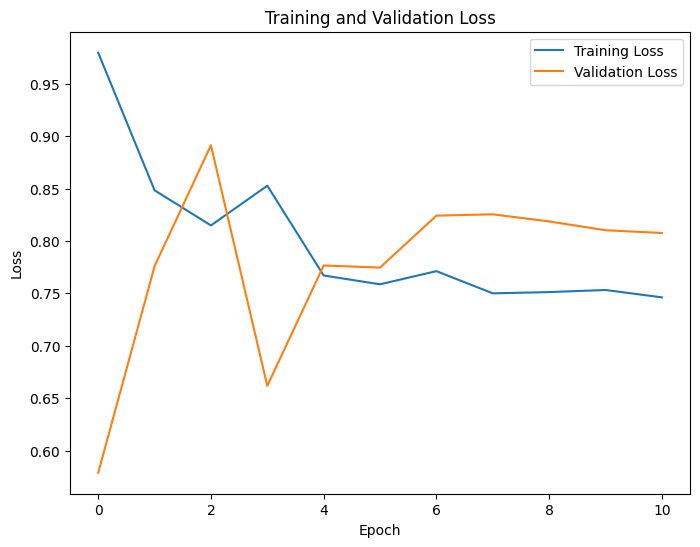

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 8. F1 Score & Classification Report

In [ ]:
y_probs = model.predict(X_test)
y_preds = np.argmax(y_probs, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 386ms/step


In [ ]:
y_probs

array([[9.9886769e-01, 1.0585483e-03, 7.3728123e-05],
       [9.9998271e-01, 1.0303621e-05, 7.0735291e-06],
       [9.9991012e-01, 6.1272447e-05, 2.8600951e-05],
       ...,
       [2.2289739e-04, 4.4905046e-05, 9.9973220e-01],
       [3.4373207e-03, 2.3752213e-03, 9.9418747e-01],
       [2.4422651e-02, 1.5317589e-04, 9.7542417e-01]], dtype=float32)

In [ ]:
y_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,

In [ ]:
f1 = f1_score(y_test, y_preds, average='weighted')
print(f"\nWeighted F1 Score: {f1:.4f}")


Weighted F1 Score: 0.9544


In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       276
           1       0.86      0.75      0.80        40
           2       0.96      0.98      0.97        44

    accuracy                           0.96       360
   macro avg       0.93      0.90      0.91       360
weighted avg       0.95      0.96      0.95       360



# 9. Confusion Matrix

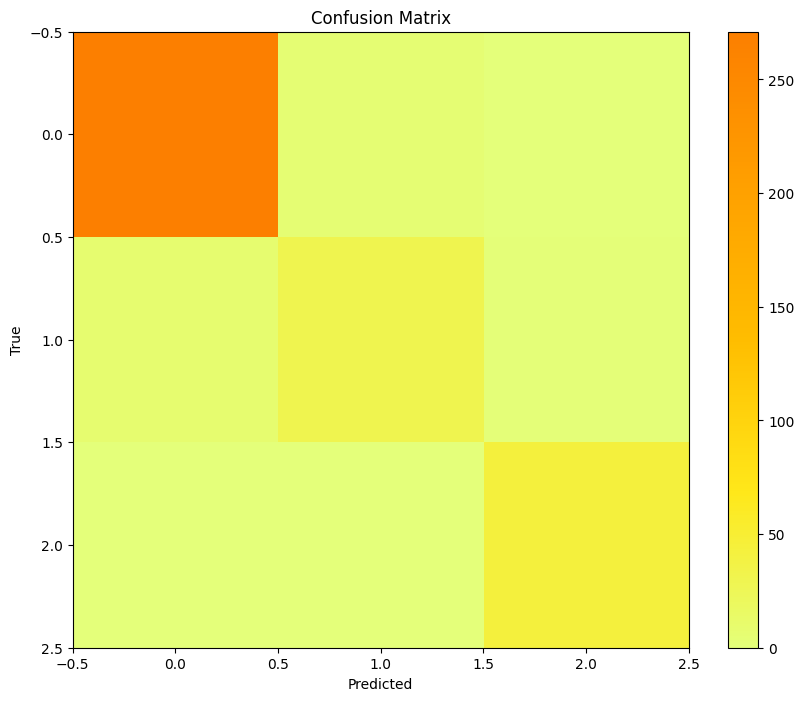

In [ ]:
cm = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap='Wistia')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

In [ ]:
cm

array([[271,   5,   0],
       [  8,  30,   2],
       [  1,   0,  43]])